<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fetch-additional-Data" data-toc-modified-id="Fetch-additional-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fetch additional Data</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run</a></span><ul class="toc-item"><li><span><a href="#Misc" data-toc-modified-id="Misc-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Misc</a></span></li></ul></li></ul></li><li><span><a href="#Generate-the-Matrix" data-toc-modified-id="Generate-the-Matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate the Matrix</a></span></li><li><span><a href="#Filter-in-size" data-toc-modified-id="Filter-in-size-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter in size</a></span></li><li><span><a href="#Filter-at-B_max" data-toc-modified-id="Filter-at-B_max-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Filter at B_max</a></span></li><li><span><a href="#Finalize" data-toc-modified-id="Finalize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Finalize</a></span></li></ul></div>

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os

In [2]:
folder_src='../../../data/'
files=['spotData_withAnnotation','spotData_withAnnotation_others']#there is also the modified file but i dunno

In [3]:
f1=pd.read_csv(folder_src+files[0]+'.csv')
# f2=pd.read_csv(folder_src+files[1]+'.csv')

# f1=f1.sort_values(['FOV_row', 'FOV_col'], ascending=[True, True])
# f2=f2.sort_values(['FOV_row', 'FOV_col'], ascending=[True, True])

In [4]:
f2=f1[np.logical_and(f1['Annotation']!='Parasite',f1['Annotation']!='Platelet')]

In [5]:
f2['Annotation']='Other'

/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
f1=f1[np.logical_or(f1['Annotation']=='Parasite',f1['Annotation']=='Platelet')]

In [7]:
f1.head()

Unnamed: 0  FOV_row  FOV_col     x     y  r      R       G      B  R_max  \
0           0       11       11  1321  1390  1  115.0   274.0  211.0   19.0   
1           1       11       11   713  1283  1  108.0   456.0  220.0   17.0   
2           2       11       11  1020  1206  1  136.0   430.0  264.0   22.0   
3           3       11       11   702  1005  1  531.0  1843.0  925.0   70.0   
4           4       11       11   616   997  1  613.0  1513.0  854.0   80.0   

   G_max  B_max  lap_total  lap_max  numPixels  numSaturatedPixels  idx  \
0   38.0   31.0      712.0    171.0         25                   0  446   
1   51.0   29.0      896.0    169.0         25                   0  418   
2   53.0   36.0     1182.0    213.0         25                   0  403   
3  187.0  110.0     3030.0    517.0         25                   0  345   
4  152.0   99.0     3056.0    414.0         25                   0  344   

                                                 URL Annotation  
0  https://octopi201910.s3-us-west-1.amazonaws.co...   Parasite  
1  https://octopi201910.s3-us-west-1.amazonaws.co...   Parasite  
2  https://octopi201910.s3-us-west-1.amazonaws.co...   Parasite  
3  https://octopi201910.s3-us-west-1.amazonaws.co...   Parasite  
4  https://octopi201910.s3-us-west-1.amazonaws.co...   Parasite

# Fetch additional Data

We want to do some exploration in order to remove as many "others" as possible (because they corrupt the classification) while eliminating as few parasites as possible. Then we want to run the classification in order to generate the achievable accuracy

Classification will be performed on another notebook (Classfication notebooks). 

## Functions

In [20]:
def extract_spot_size(df,path_to_pictures):
    spot_size=[]
    for crt_row in df.index:

        FOV_x=df.loc[crt_row,'FOV_col']
        FOV_y=df.loc[crt_row,'FOV_row']
        x=df.loc[crt_row,'x']
        y=df.loc[crt_row,'y']

        #load image
        filename='_'+str(FOV_y).zfill(4)+'_'+str(FOV_x).zfill(4)+'_'+"fluorescent.png"

        I=plt.imread(path_to_pictures+filename)

        dd=5
        x_start=max(0,x-dd)
        x_end=min(x+dd,I.shape[1])
        y_start=max(0,y-dd)
        y_end=min(y+dd,I.shape[0])

        spot=I[y_start:y_end,x_start:x_end,:]
        spot=np.sum(spot,axis=2)

        spot_size.append(np.sum(spot>1/3*np.max(spot)))
    return spot_size

In [9]:
def viz_spot(df,row,bin=True):
    FOV_x=df.loc[row,'FOV_col']
    FOV_y=df.loc[row,'FOV_row']
    x=df.loc[row,'x']
    y=df.loc[row,'y']

    #load image
    filename='_'+str(FOV_y).zfill(4)+'_'+str(FOV_x).zfill(4)+'_'+"fluorescent.png"
    I=plt.imread(path_to_pictures+filename)
    dd=5
    x_start=max(0,x-dd)
    x_end=min(x+dd,I.shape[1])
    y_start=max(0,y-dd)
    y_end=min(y+dd,I.shape[0])

    spot=I[y_start:y_end,x_start:x_end,:]
    if bin:
        spot=np.sum(spot,axis=2)
    
    plt.imshow(spot)

And then we need to test on the spots that have been identified as being super biiiig

## Run

In [16]:
path_to_pictures='/Volumes/Extreme SSD/Octopi low mag/3C Octopi - tophat filter r = 8_corrected/BGremoved/'

In [21]:
spot_size_f1=extract_spot_size(f1,path_to_pictures)
spot_size_f2=extract_spot_size(f2,path_to_pictures)

In [22]:
print(len(spot_size_f1))
print(len(spot_size_f2))

1885
679


In [24]:
f1['size']=spot_size_f1
f2['size']=spot_size_f2

### Misc

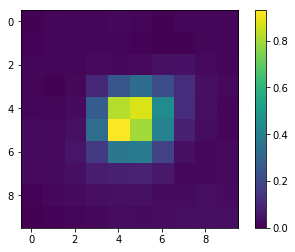

In [180]:
plt.imshow(spot)
plt.colorbar()

In [150]:
max_val=np.max(spot)
idx=np.where(spot==max_val)
x=idx[0][0]
y=idx[1][0]

In [ ]:
for i in range(1,dd):
    
    if spot[y+i]

In [147]:
np.max(spot)

0.94117653

# Generate the Matrix

In [26]:
indx_to_remove=[0,1,2,3,4,5,14,15,16,17] #sometimes have to add 18

cols_to_remove=f1.columns[indx_to_remove]

f1_=f1.drop(cols_to_remove,axis=1)
f2_=f2.drop(cols_to_remove,axis=1)

In [27]:
f1_.head()

R       G      B  R_max  G_max  B_max  lap_total  lap_max Annotation  \
0  115.0   274.0  211.0   19.0   38.0   31.0      712.0    171.0   Parasite   
1  108.0   456.0  220.0   17.0   51.0   29.0      896.0    169.0   Parasite   
2  136.0   430.0  264.0   22.0   53.0   36.0     1182.0    213.0   Parasite   
3  531.0  1843.0  925.0   70.0  187.0  110.0     3030.0    517.0   Parasite   
4  613.0  1513.0  854.0   80.0  152.0   99.0     3056.0    414.0   Parasite   

   size  
0     6  
1     7  
2     9  
3    10  
4    11

In [28]:
f2_.head()

R       G       B  R_max  G_max  B_max  lap_total  lap_max  \
25  2985.0  5640.0  5552.0  153.0  241.0  242.0     3090.0    302.0   
27  1190.0  5294.0  5243.0   79.0  230.0  237.0     2086.0    287.0   
38    80.0   210.0   147.0   16.0   32.0   25.0      664.0    126.0   
59   114.0   851.0   442.0   16.0   69.0   44.0      996.0    188.0   
61   126.0   479.0   542.0   13.0   41.0   46.0     1022.0    114.0   

   Annotation  size  
25      Other    80  
27      Other    71  
38      Other     6  
59      Other     7  
61      Other    31

In [32]:
f1_.insert(f1_.shape[1],"R/B",np.divide(f1_['R'],f1_['B']))
f1_.insert(f1_.shape[1],"G/B",np.divide(f1_['G'],f1_['B']))
f2_.insert(f2_.shape[1],"R/B",np.divide(f2_['R'],f2_['B']))
f2_.insert(f2_.shape[1],"G/B",np.divide(f2_['G'],f2_['B']))

In [33]:
f3=pd.concat([f1_,f2_])

<Figure size 1440x1440 with 0 Axes>

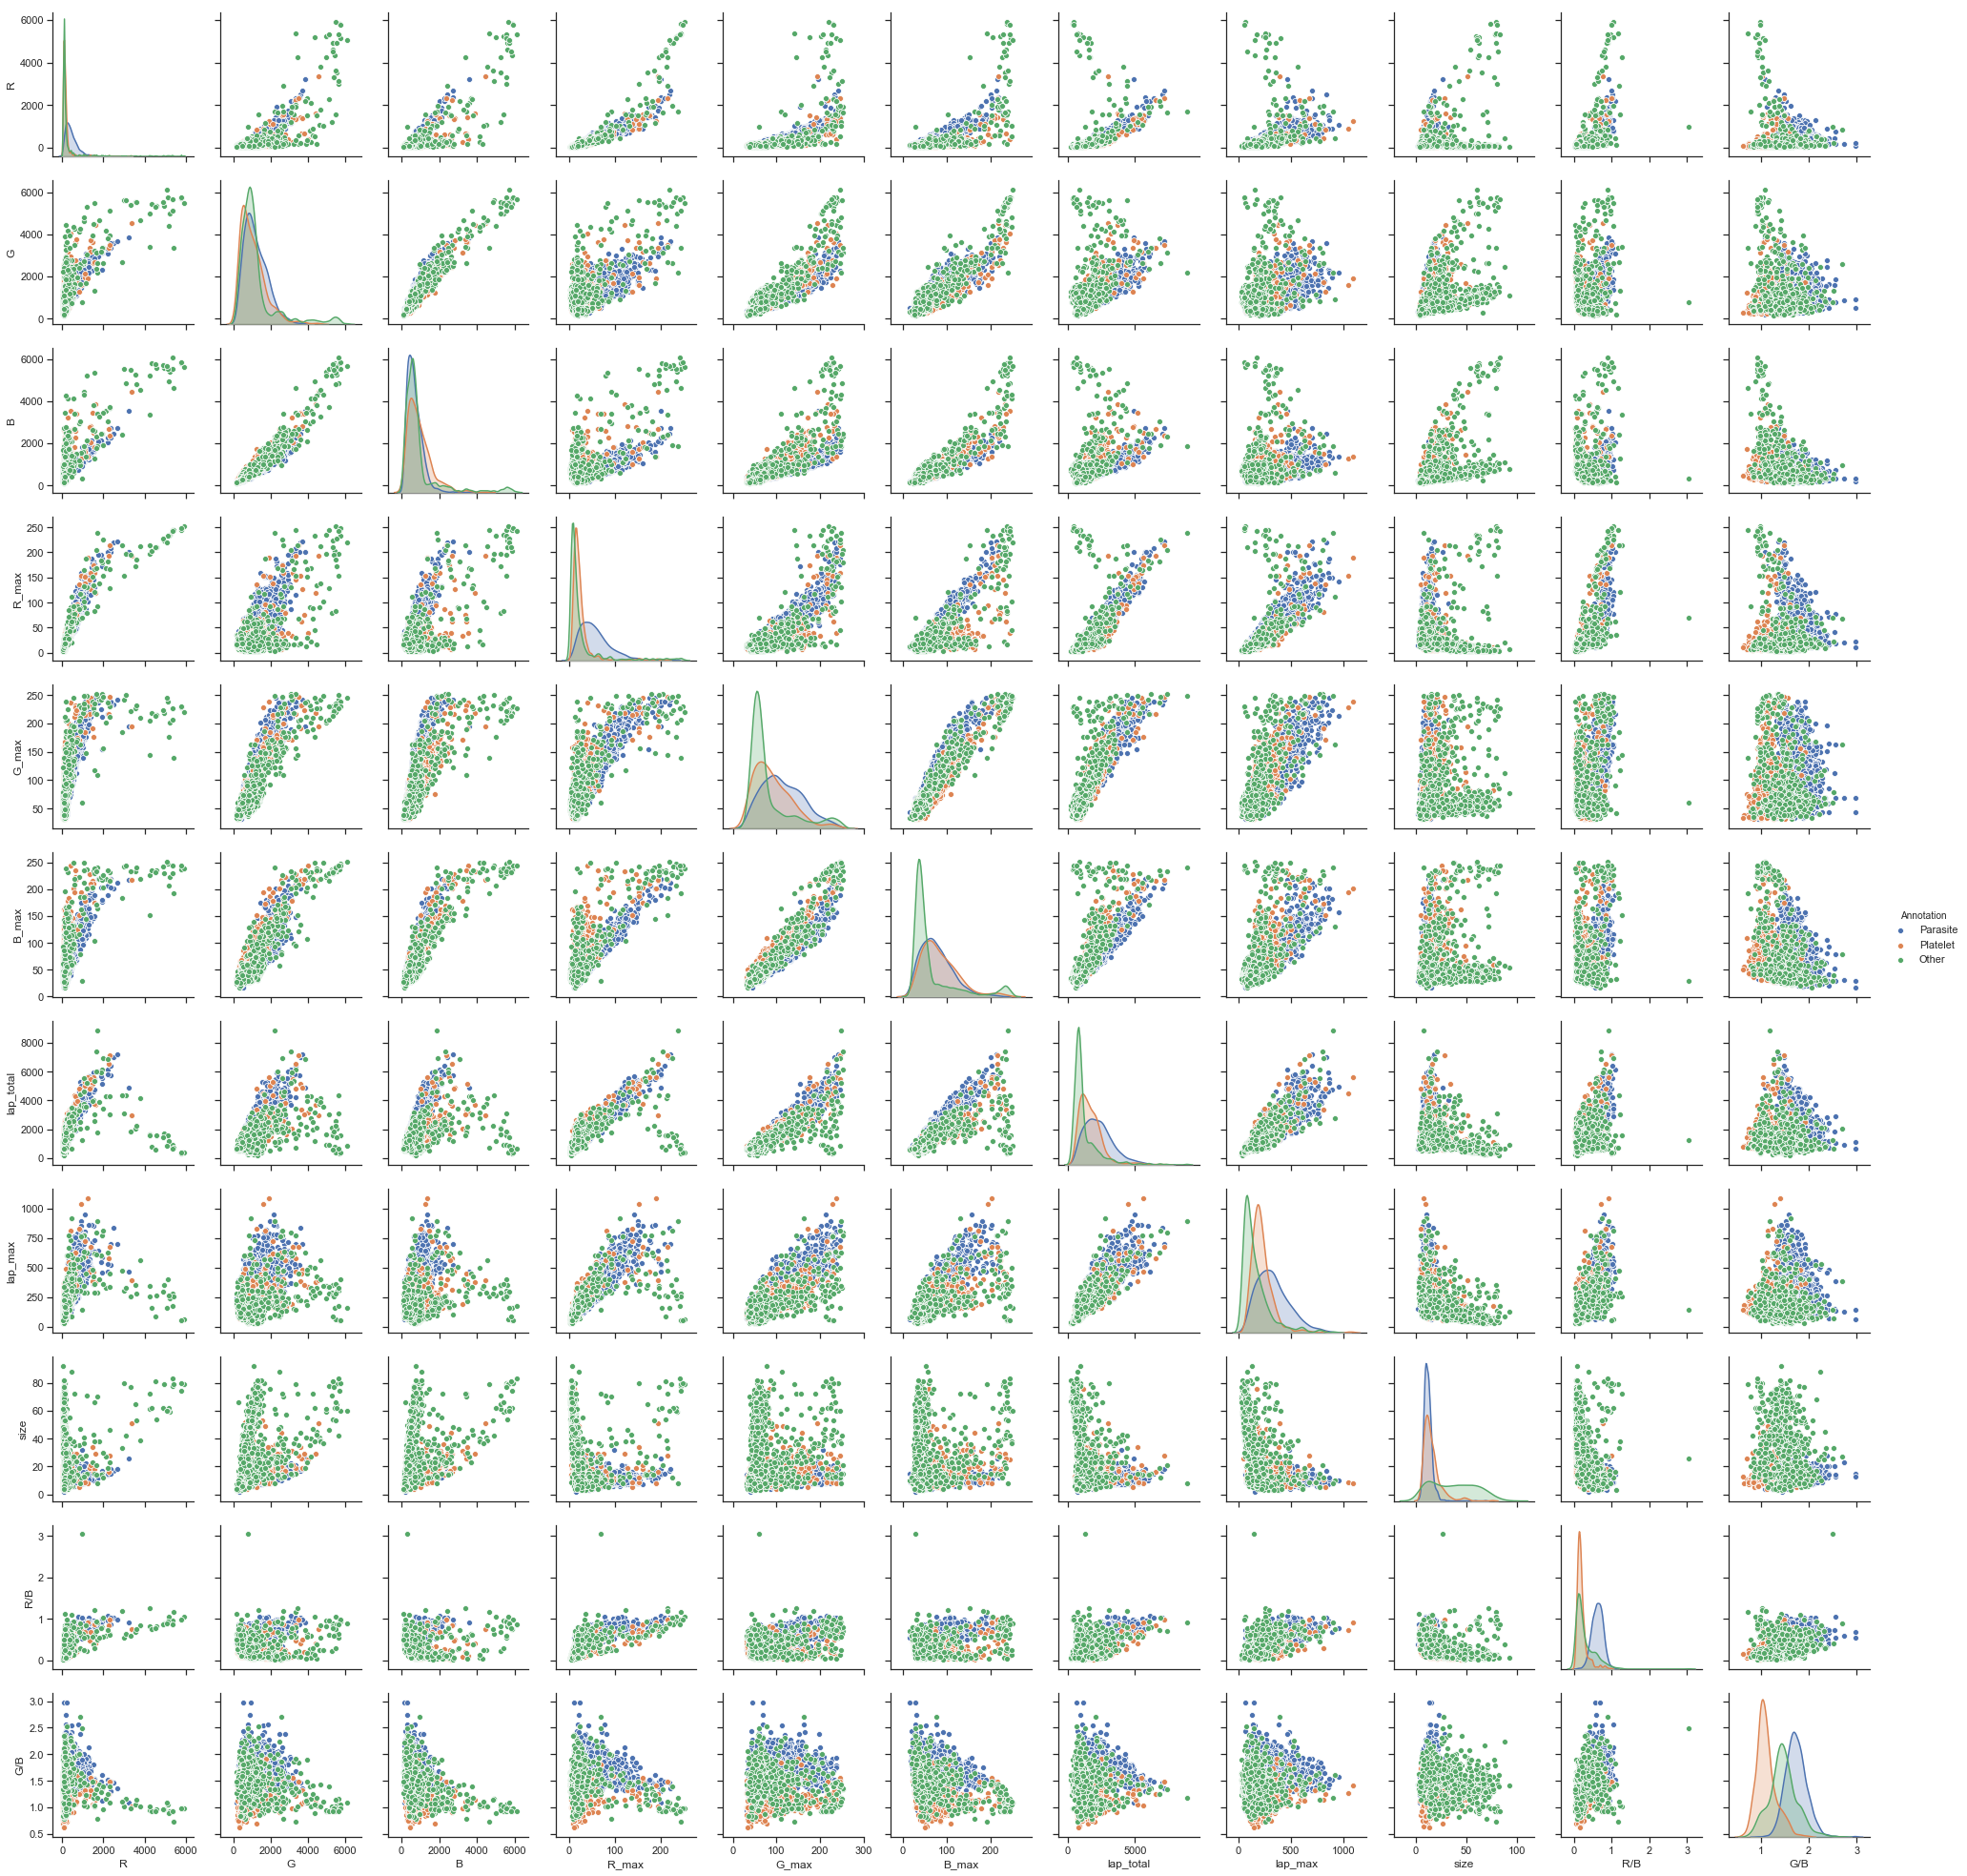

In [34]:
sns.set(style="ticks")
plt.figure(figsize=(20,20))
sns.pairplot(f3, hue="Annotation")
# .savefig("output.png")
# plt.savefig("output_others.png")

# Filter in size

It seems that with that many labels, filtering in size might be a good idea

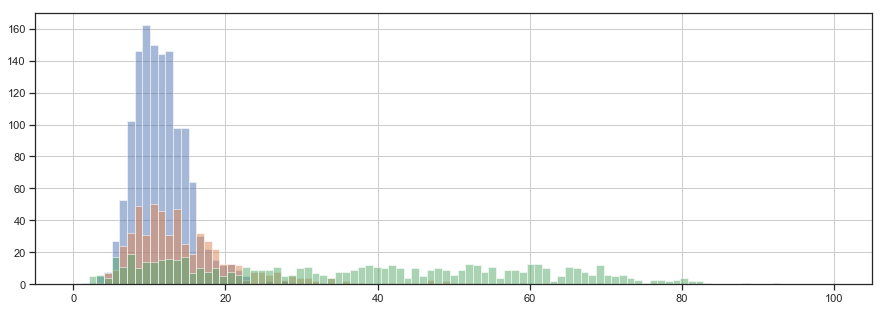

In [47]:
plt.figure(figsize=(15,5))
plt.hist(f3[f3['Annotation']=='Parasite']['size'],np.linspace(0,100,100),alpha=0.5);
plt.hist(f3[f3['Annotation']=='Platelet']['size'],np.linspace(0,100,100),alpha=0.5);
plt.hist(f3[f3['Annotation']=='Other']['size'],np.linspace(0,100,100),alpha=0.5);
plt.grid(True)

/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


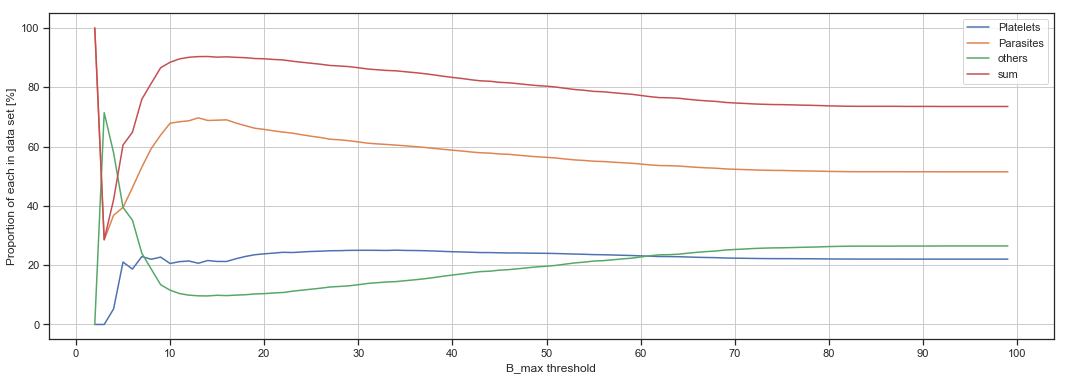

In [62]:
threshold_analysis_below(f3,'size',np.linspace(0,100,100))

/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


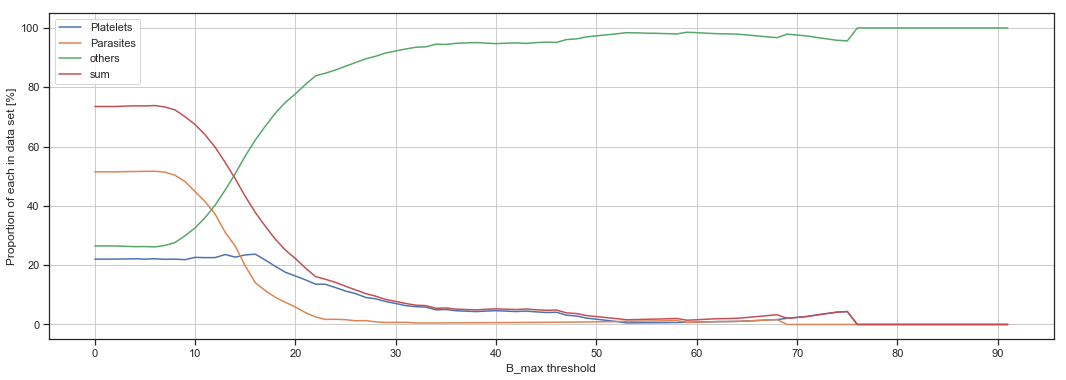

In [61]:
threshold_analysis_above(f3,'size',np.linspace(0,100,100))

In [63]:
th=20

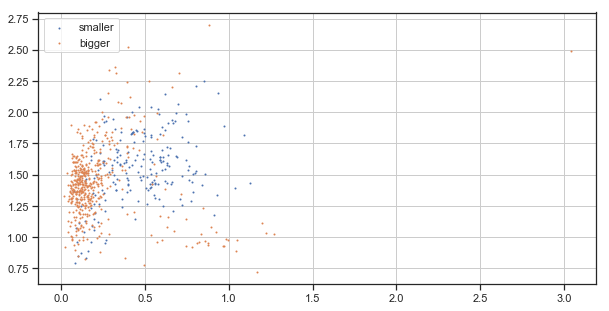

In [66]:
plt.figure(figsize=(10,5))
indx1=np.logical_and(f3['Annotation']=='Other',f3['size']<=th)
indx2=np.logical_and(f3['Annotation']=='Other',f3['size']>th)
plt.scatter(f3[indx1]['R/B'],f3[indx1]['G/B'],label='smaller',s=1)
plt.scatter(f3[indx2]['R/B'],f3[indx2]['G/B'],label='bigger',s=1)
plt.grid(True)
plt.legend()


In [67]:
f3_bis=f3[f3['size']<=th]

<Figure size 1440x1440 with 0 Axes>

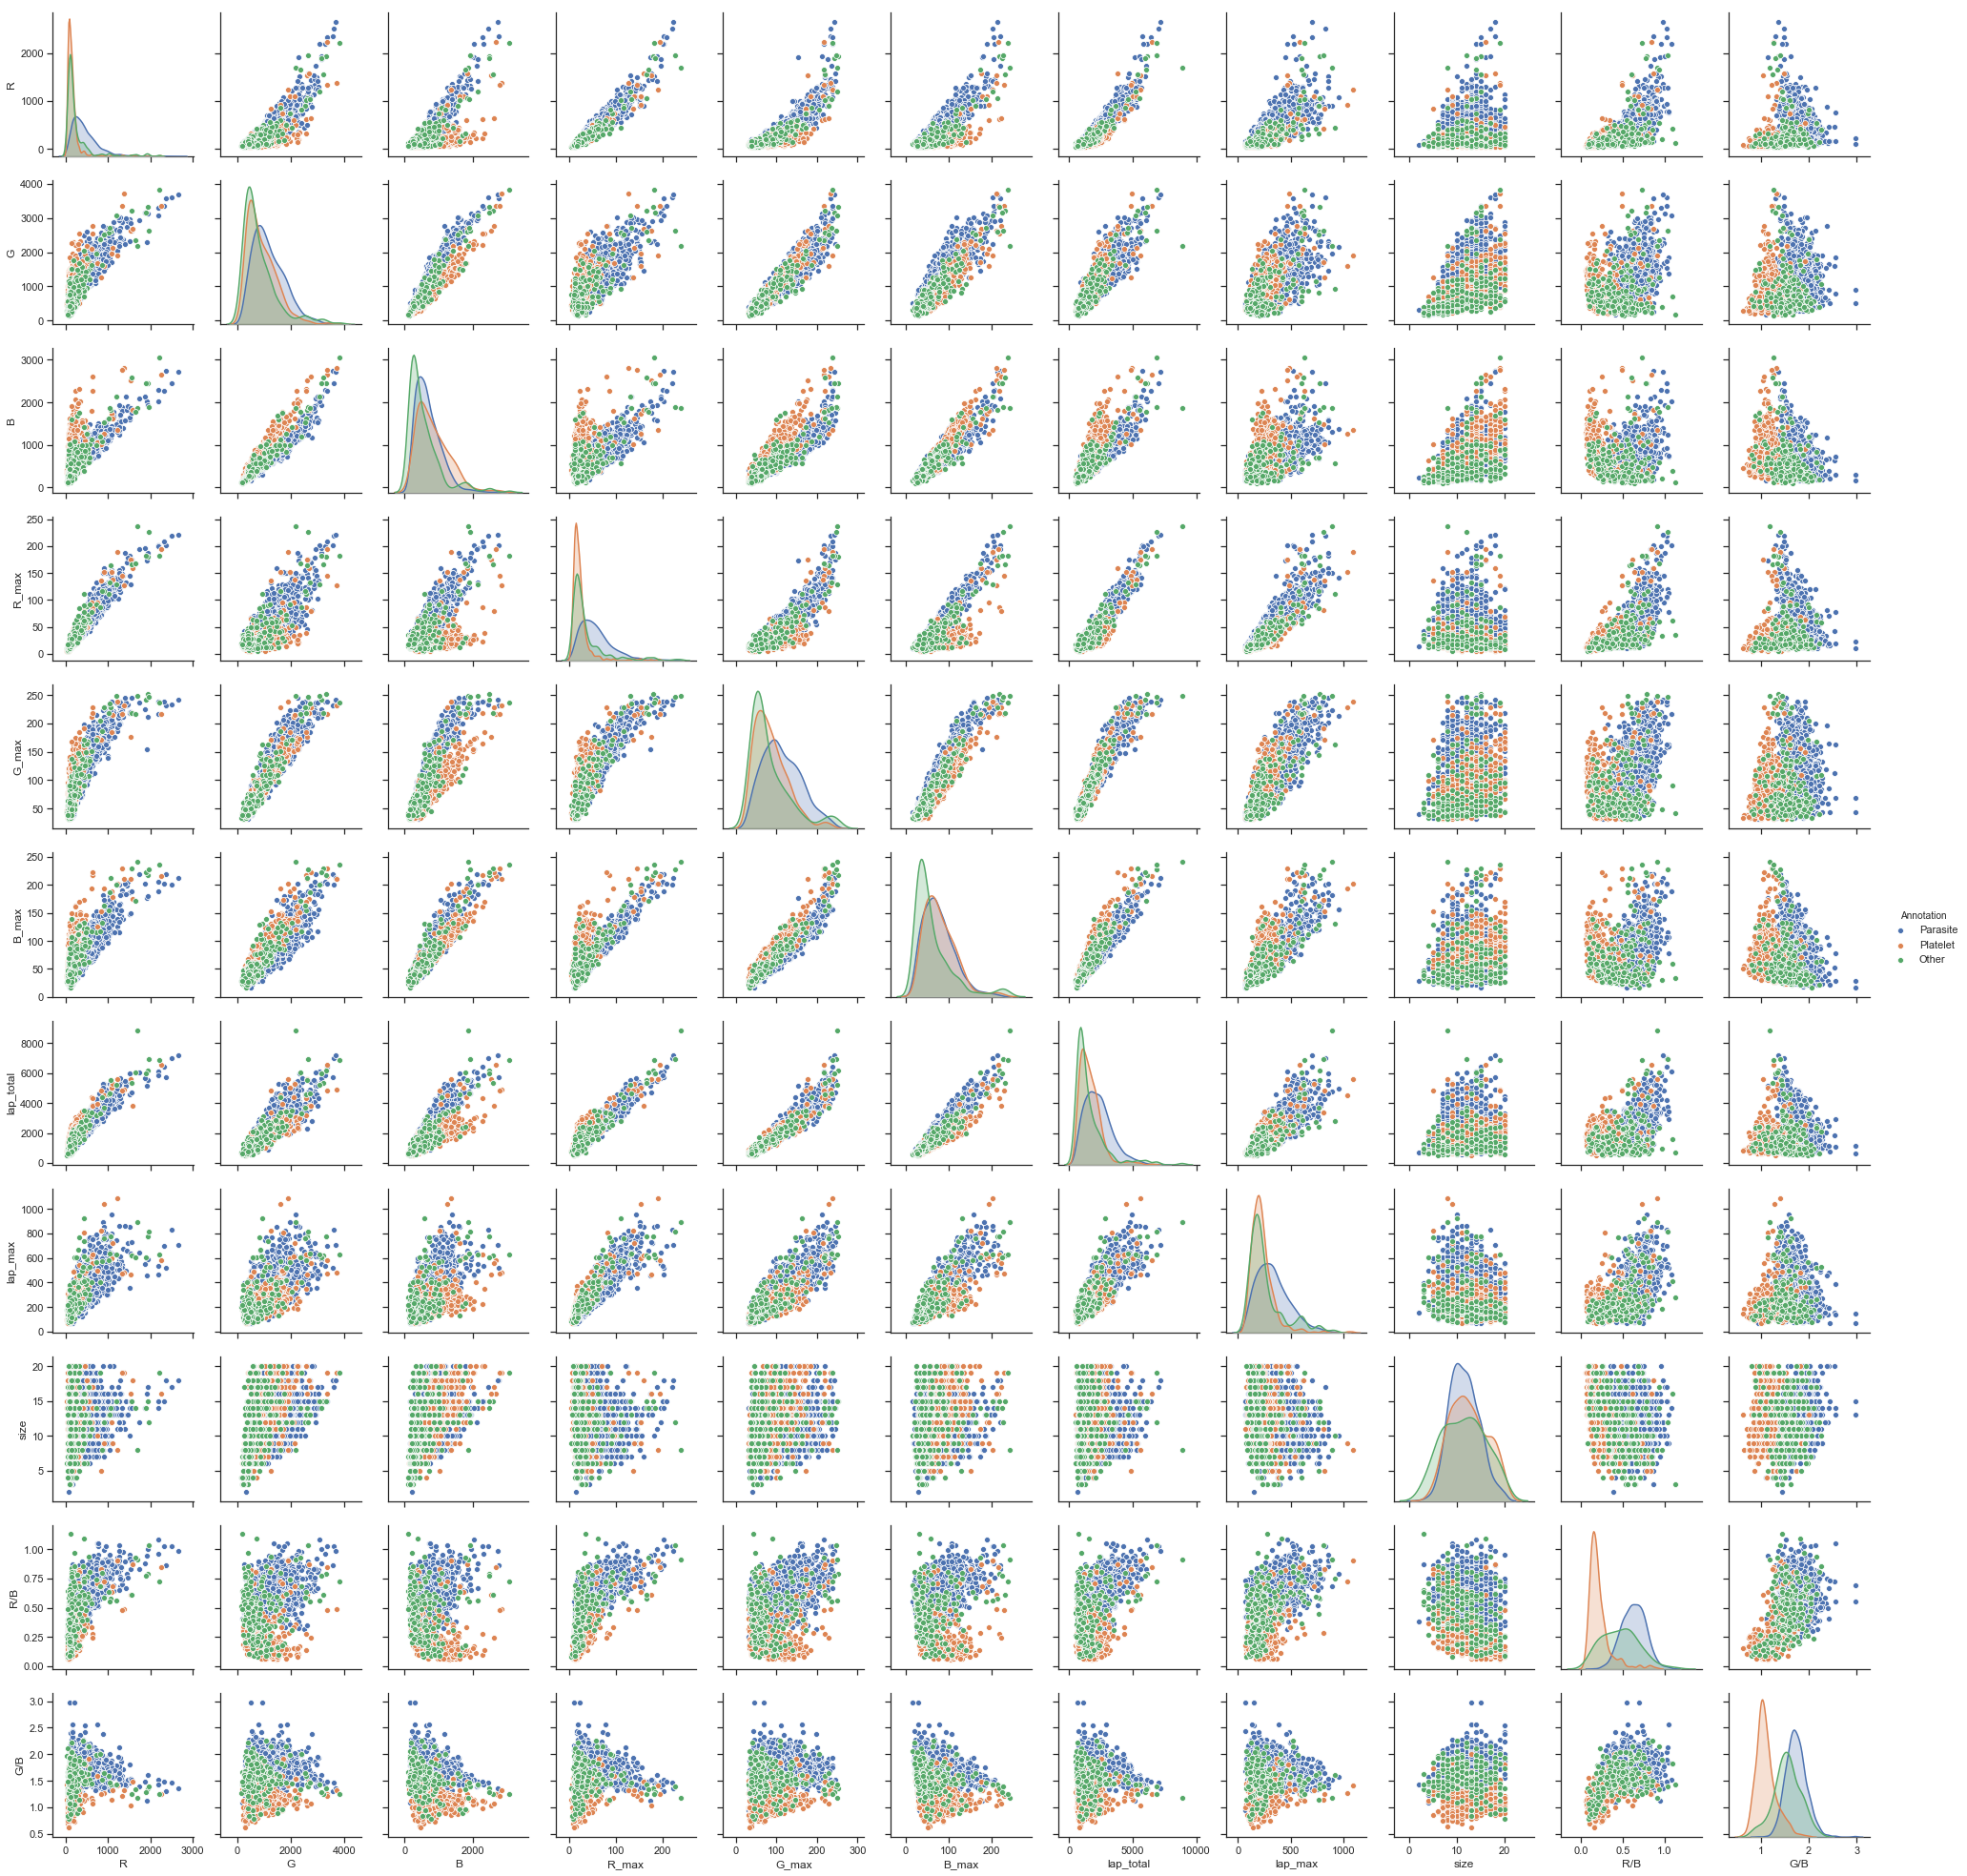

In [70]:
sns.set(style="ticks")
plt.figure(figsize=(20,20))
sns.pairplot(f3_bis, hue="Annotation")
# .savefig("output.png")
# plt.savefig("output_others.png")

# Filter at B_max

In [54]:
np.unique(f3['Annotation'])

array(['Other', 'Parasite', 'Platelet'], dtype=object)

In [59]:
def threshold_analysis_below(df,feature,th):
    pl=[]
    pa=[]
    others=[]

    for _th in th:
        pl.append(np.sum(np.logical_and(df[feature]<=_th,df['Annotation']=='Platelet'))/np.sum(df[feature]<=_th))
        pa.append(np.sum(np.logical_and(df[feature]<=_th,df['Annotation']=='Parasite'))/np.sum(df[feature]<=_th))
        others.append(np.sum(np.logical_and(df[feature]<=_th,df['Annotation']=='Other'))/np.sum(df[feature]<=_th))

    pl=np.array(pl)
    pa=np.array(pa)
    others=np.array(others)
    
    #plot
    plt.figure(figsize=(18,6))
    plt.plot(pl*100,label='Platelets')
    plt.plot(pa*100,label="Parasites")
    plt.plot(others*100,label="others")
    plt.plot((pl+pa)*100,label="sum")
    plt.xlabel("B_max threshold")
    plt.ylabel("Proportion of each in data set [%]")
    plt.grid(True)
    plt.legend()
    plt.locator_params(axis='x', nbins=13)

In [60]:
def threshold_analysis_above(df,feature,th):
    pl=[]
    pa=[]
    others=[]

    for _th in th:
        pl.append(np.sum(np.logical_and(df[feature]>=_th,df['Annotation']=='Platelet'))/np.sum(df[feature]>=_th))
        pa.append(np.sum(np.logical_and(df[feature]>=_th,df['Annotation']=='Parasite'))/np.sum(df[feature]>=_th))
        others.append(np.sum(np.logical_and(df[feature]>=_th,df['Annotation']=='Other'))/np.sum(df[feature]>=_th))

    pl=np.array(pl)
    pa=np.array(pa)
    others=np.array(others)
    
    #plot
    plt.figure(figsize=(18,6))
    plt.plot(pl*100,label='Platelets')
    plt.plot(pa*100,label="Parasites")
    plt.plot(others*100,label="others")
    plt.plot((pl+pa)*100,label="sum")
    plt.xlabel("B_max threshold")
    plt.ylabel("Proportion of each in data set [%]")
    plt.grid(True)
    plt.legend()
    plt.locator_params(axis='x', nbins=13)

In [59]:
th=np.linspace(1,255,255)

In [62]:
pl=[]
pa=[]
others=[]

for _th in th:
    pl.append(np.sum(np.logical_and(f3['B_max']>=_th,f3['Annotation']=='Platelet'))/np.sum(f3['B_max']>=_th))
    pa.append(np.sum(np.logical_and(f3['B_max']>=_th,f3['Annotation']=='Parasite'))/np.sum(f3['B_max']>=_th))
    others.append(np.sum(np.logical_and(f3['B_max']>=_th,f3['Annotation']=='Others'))/np.sum(f3['B_max']>=_th))
    
pl=np.array(pl)
pa=np.array(pa)
others=np.array(others)

/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/Users/lucasfuentes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


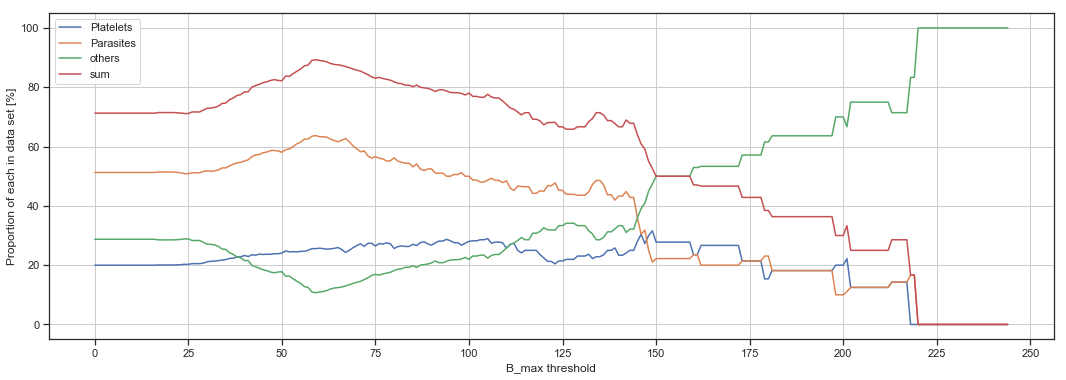

In [69]:
plt.figure(figsize=(18,6))
plt.plot(pl*100,label='Platelets')
plt.plot(pa*100,label="Parasites")
plt.plot(others*100,label="others")
plt.plot((pl+pa)*100,label="sum")
plt.xlabel("B_max threshold")
plt.ylabel("Proportion of each in data set [%]")
plt.grid(True)
plt.legend()
plt.locator_params(axis='x', nbins=13)

In [109]:
th_=60
th_up=200
f4=f3[f3['B_max']>=th_]
f4=f4[f4['B_max']<=th_up]
f4=f4[f4['G']<=3000]
f4=f4[f4['R_max']<=150]

In [110]:
print(np.sum(f4['Annotation']=='Platelet'))

print(np.sum(f3['Annotation']=='Platelet'))

52
71


In [111]:
print(np.sum(f4['Annotation']=='Parasite'))

print(np.sum(f3['Annotation']=='Parasite'))

133
182


In [112]:
print(np.sum(f4['Annotation']=='Others'))

print(np.sum(f3['Annotation']=='Others'))

13
102


<Figure size 1440x1440 with 0 Axes>

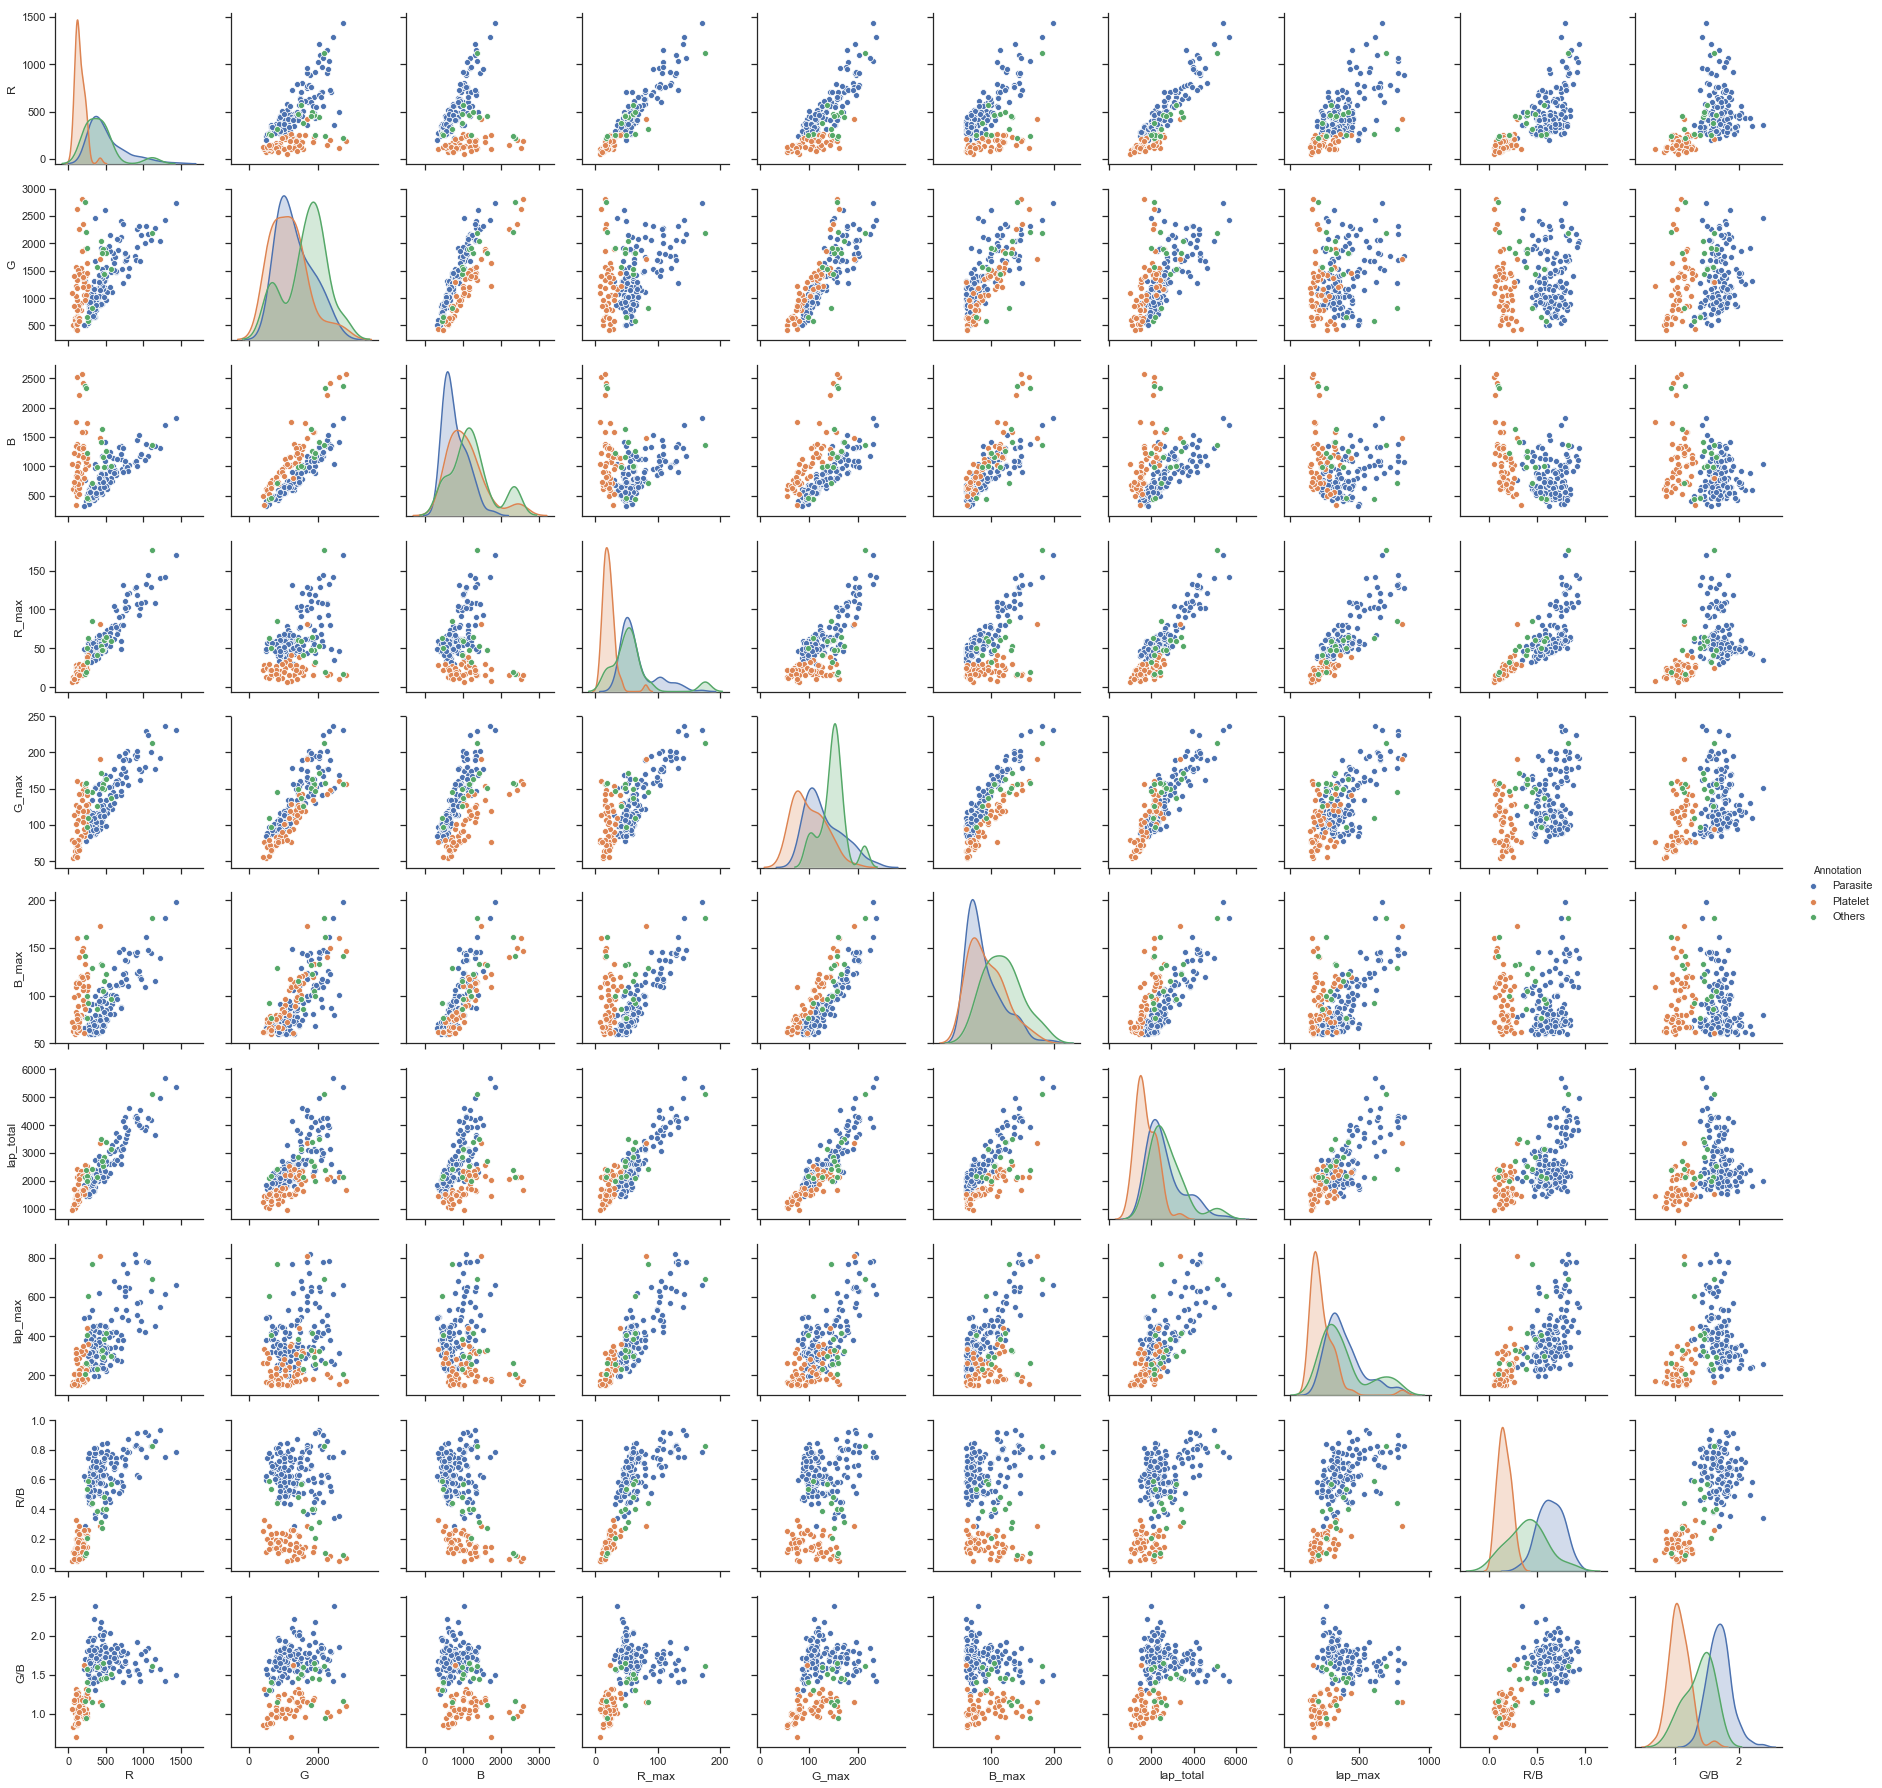

In [106]:
sns.set(style="ticks")
plt.figure(figsize=(20,20))
sns.pairplot(f4, hue="Annotation")
# .savefig("output.png")
plt.savefig("output_threshold.png")

In [107]:
np.sum(f3['Annotation']=='Others')/f3.shape[0]

0.28732394366197184

In [108]:
np.sum(f4['Annotation']=='Others')/f4.shape[0]

0.07

# Finalize

In [72]:
df_final=pd.concat([f1,f2])

Size

In [73]:
th_size=20

In [74]:
df_final=df_final[df_final['size']<=th_size]

In [79]:
df_final.to_csv(os.path.join(folder_src,'spotData_filtered.csv'))